In [4]:
import pandas as pd
# import geopandas as gpd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs

# from shapely.geometry import Point
from pathlib import Path

import helper

from warnings import filterwarnings
filterwarnings("ignore")

%matplotlib inline

In [5]:
# accidents = pd.read_csv("./data/accident.csv")
accidents = pd.read_csv("./data/accidents_clean.csv")
lookup = pd.read_csv(r'./data/road-safety-lookups.csv')
# shapes
print("accidents: ", accidents.shape)

accidents:  (91185, 40)


In [6]:
# change date col from object to datetime
accidents.date = pd.to_datetime(accidents.date, dayfirst=True)

# EDA

Most of the variables in our data are mostly nominal except for the accident_severity and casualty. We will start from the distribution of major accidents, casuality, and accident severity in our dataset.

## Distribution of Accidents by Severity

In [7]:
# color schemes
urban_rural_cmap = ["slateblue", "springgreen"]
severity_cmap = ["red", "orange", "grey"]
maj_non_maj_cmap = ["bisque", "red"]

In [8]:
# view numbers of major and non-major accidents (by definition of Safety team)
accidents.is_major_accident.value_counts()

False    90983
True       202
Name: is_major_accident, dtype: int64

In [ ]:
# make figure
plt.figure(figsize=(10,7))

# add grid axes
ax = plt.gca()
grid_layout = gs.GridSpec(4,3)
top = plt.subplot(grid_layout[:2,:1])
left = plt.subplot(grid_layout[2:,:2])
right = plt.subplot(grid_layout[2:,2])

# plot pie chart of major & non major percents
major_acc_ratio = accidents.is_major_accident.value_counts()
major_acc_ratio.plot.pie(ax=top, autopct="%.1f%%", labels=["Non-major", "Major"], colors=maj_non_maj_cmap)
top.set_ylabel("")
top.set_title("Percent of Major Accidents")

# draw distribution of number of casualties
casualty_count = accidents.number_of_casualties.value_counts()
left.bar(x=casualty_count.index, height=casualty_count.values, color="orange", alpha=0.5)
left.set_xticks(np.arange(1,42,3))
left.set_title("Frequency Distribution of Number of Casualties in 2020")
left.set_xlabel("Number of Casualties")
left.set_ylabel("Frequency")

# plot pie chart of accident severity percents
severity_ratio = accidents.accident_severity.value_counts()
severity_ratio.plot.pie(autopct="%.1f%%", ax=right, colors=severity_cmap[::-1])
right.set_title("Accident Severity Ratio")
right.set_ylabel("")
plt.tight_layout()

The frequency distribution of accident casualties shows that one or two casualties are the most common throughout 2020 with very few outliers reaching up to 41 casualties. In terms of severity, around 20% are serious and 1.5% fatal although the major accidents were only 0.2% of the total accidents. 

In this report, we will observe patterns related to severe major accidents and propose some aspects that safety team should focus on in order to reduce the number of major accidents.

EDA process can be broadly categorized as follows.
<b>
1. Location and Time,
2. Road characteristics,
3. Weather and environmental influences, and
4. Humans
***

## TIME
Are there any patterns in the time of day/ day of the week when major incidents occur?

### Accident by Hour
Since the number of major accidents are very few compared to total accidents, normalized line chart was used to  compared and visualize the hourly variations.

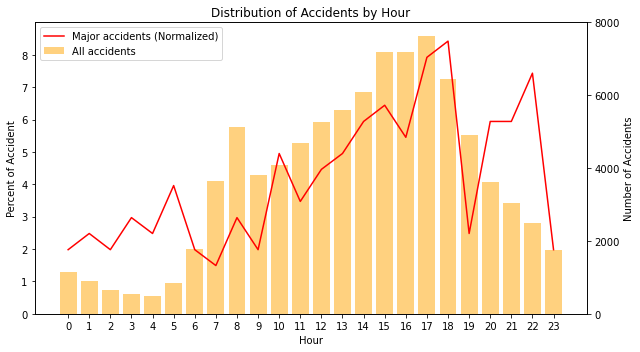

In [9]:
# get hourly accident counts
all_hourly_count = accidents["hour"].value_counts().sort_index()
hourly_major_count = accidents[accidents.is_major_accident==1]["hour"].value_counts().sort_index()

# normalize counts with their own sum respectively
all_normed = np.round(100*(all_hourly_count/all_hourly_count.sum()),2)
normed_maj = np.round(100*(hourly_major_count/hourly_major_count.sum()),2)

# make figure
plt.figure(figsize=(9,5))
ax1 = plt.gca()

# make hourly distribution
plt.bar(x=all_normed.index, height=all_normed.values, label="All accidents", color="orange", alpha=0.5)
# make hourly major accident percent
plt.plot(normed_maj.values, color="red", label="Major accidents (Normalized)")

# modify left axis
plt.xticks(np.arange(0,24,1))
ax1.set_ylabel("Percent of Accident")
ax1.set_xlabel("Hour")
ax1.legend()

# make right axis
ax2 = ax1.twinx()
ax2.set_ylim(ax1.get_ylim())
ax2.set_yticks(np.arange(0, all_hourly_count.sum()*(ax1.get_ylim()[1]/100), 2000))
ax2.set_ylabel("Number of Accidents")

plt.title("Distribution of Accidents by Hour")
plt.tight_layout();

Despite having very few data points, the hourly trend of major accidents roughly follows that of non-major accidents. The number of accidents increases as it gets closer to evening 4-5PM and gradually decreases towards the midnight.

Both distributions seems to be bimodal with different peaks. Both major and all accidents are the highest around 4-5PM in the evening. Major accidents have a peak around 11PM while all accident aggregation have a peak in the morning. Therefore, safety team should focus on accidents and traffic in the evening to midnight to find ways to reduce major accidents.

Upon further exploration to see the hourly counts of accidents with different severity, we find that both slight and serious accidents also follows the same trend as shown in the figure below.

In [8]:
hourly_severity = pd.crosstab(accidents.hour, accidents.accident_severity)
hourly_severity

accident_severity,Fatal,Serious,Slight
hour,,,
0,40,291,857
1,34,236,645
2,39,170,449
3,30,129,407
4,25,125,358
5,34,219,601
6,40,409,1381
7,35,716,2985
8,52,883,4330


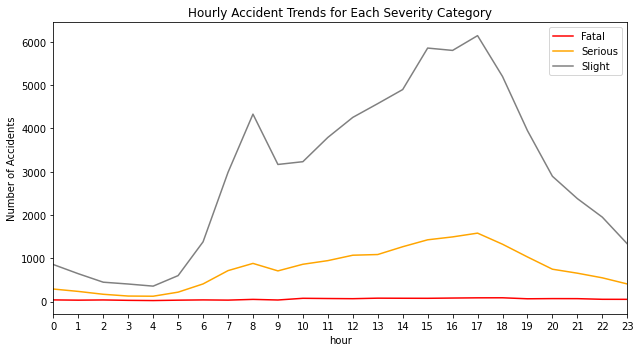

In [9]:
plt.figure(figsize=(9,5))

color_idx = 0
for col in hourly_severity.columns:
    # plot line
    sns.lineplot(x=hourly_severity[col].index, y=hourly_severity[col].values, color=severity_cmap[color_idx])
    color_idx += 1 # index for cmap
    
plt.xticks(np.arange(0,24,1))
plt.xlim([0,23])
plt.ylabel("Number of Accidents")
plt.legend(["Fatal", "Serious", "Slight"])
plt.title("Hourly Accident Trends for Each Severity Category")
plt.tight_layout()

According to the UK government's [Annual Road Trafc Estimates for 2020](https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/1028165/road-traffic-estimates-in-great-britain-2020.pdf) the hourly average traffic volume peaks are 7am-9am and 4pm-5pm.

Since our accident trends closely follows this average traffic volume, we can say that <span style="color:green">major accidents are most likely to occur during the rash hour, midnight,</span> and the hourly trend of accident is consistent regardless of severity level.

Next, we'll see how hourly accident trend varies between urban and rural areas.

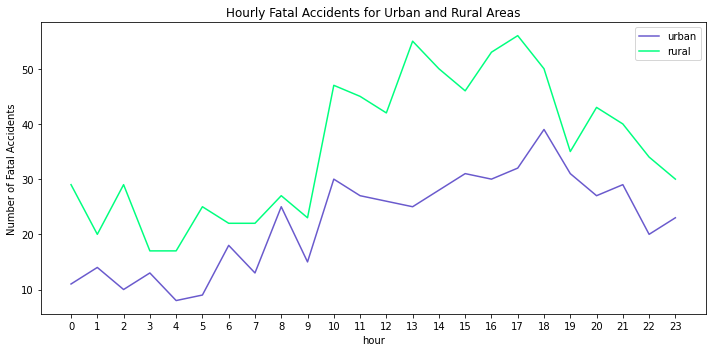

In [10]:
urban_data = accidents.query("(urban_or_rural_area=='Urban') & (accident_severity=='Fatal')")
urban_data = pd.crosstab(urban_data.hour, urban_data.accident_severity)

rural_data = accidents.query("(urban_or_rural_area=='Rural') & (accident_severity=='Fatal')")
rural_data = pd.crosstab(rural_data.hour, rural_data.accident_severity)

plt.figure(figsize=(10,5))
ax = plt.gca()
sns.lineplot(x=urban_data.index, y=urban_data["Fatal"], color=urban_rural_cmap[0], label="urban")
sns.lineplot(x=rural_data.index, y=rural_data["Fatal"], color=urban_rural_cmap[1], label="rural")
ax.set_xticks(urban_data.index)
ax.set_ylabel("Number of Fatal Accidents")
ax.set_title("Hourly Fatal Accidents for Urban and Rural Areas")
plt.legend()
plt.tight_layout()

In general, rural areas have more hourly fatal accidents than urban areas. The trend of accident is about the same. Both graually get highers towards the evening. In the location section later, we'll have a look at why rural accidents have higher number of fatal accidents. 

### Accident by Days of Week

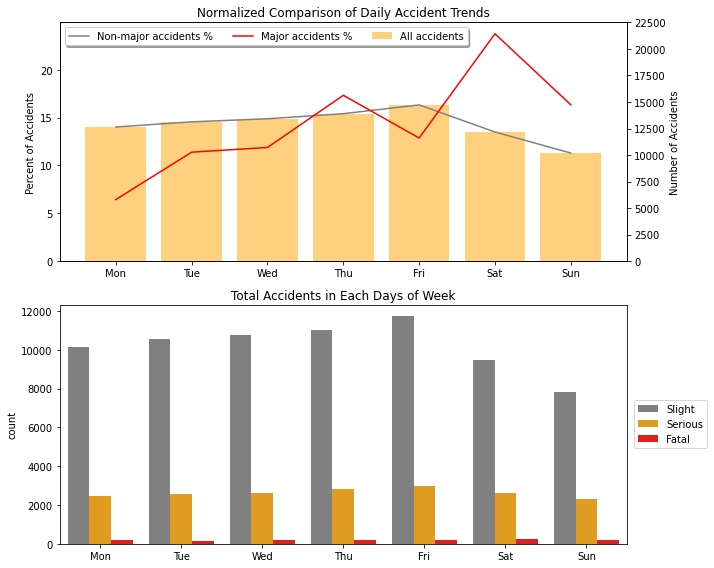

In [11]:
day_name = {2: "Mon", 3: "Tue", 4: "Wed", 5: "Thu", 6: "Fri", 7: "Sat", 1: "Sun"}

# get data for all, major, minor accidents by day of week
all_daily_count = accidents["day_of_week"].value_counts()
daily_major_count = accidents[accidents.is_major_accident==1]["day_of_week"].value_counts()
daily_non_major_count = accidents[accidents.is_major_accident==0]["day_of_week"].value_counts()

# replace day numbers with names
all_daily_count = all_daily_count.rename(index=day_name).reindex(day_name.values())
daily_major_count = daily_major_count.rename(index=day_name).reindex(day_name.values())
daily_non_major_count = daily_non_major_count.rename(index=day_name).reindex(day_name.values())

# normalize both counts with their own sum respectively
all_normed = np.round(100*(all_daily_count/all_daily_count.sum()),2)
normed_maj = np.round(100*(daily_major_count/daily_major_count.sum()),2)
normed_non_maj = np.round(100*(daily_non_major_count/daily_non_major_count.sum()),2)

# create figure
fig, (upper, lower) = plt.subplots(2,1, figsize=(10,8))

# draw trend comparison between major and non-major by day of week 
upper.bar(x=all_normed.index, height=all_normed.values, color="orange", alpha=0.5, label="All accidents")
upper.plot(normed_non_maj.values, color="grey", label="Non-major accidents %")
upper.plot(normed_maj.values, color="red", label="Major accidents %")

upper.legend(loc="upper left", ncol=3, fancybox=True, shadow=True)
upper.set_ylabel("Percent of Accidents")
upper.set_title("Normalized Comparison of Daily Accident Trends")

# make upper Y-twin (right)
upper_twinax = upper.twinx()
upper_twinax.set_ylim(upper.get_ylim())
upper_twinax.set_yticks(np.arange(0, all_daily_count.sum()*(upper.get_ylim()[1]/100), 2500))
upper_twinax.set_ylabel("Number of Accidents")

# draw severity comparison by day of week
sns.countplot(data=accidents, x="day_of_week", hue="accident_severity", ax=lower,
              palette=severity_cmap[::-1], order=day_name.keys())
lower.set_title("Total Accidents in Each Days of Week")
lower.set_xticklabels(list(day_name.values()))
lower.set_xlabel("")
lower.legend(loc="center right", bbox_to_anchor=(1.15, 0.5))

plt.tight_layout()

Again, we used the normalized values in the upper plot for comparing variations by day. Non-major accidents are relatively low in weekends. However, major accidents reaches the highest at weekends, gradually increasing from Monday. <span style="color:blue">*Although the scope of Datacamp's competition is for 2020 data, we could use the data for other years so that we can compare yearly distributions and reinforce our conclusions.*</span>

### Accident by Month

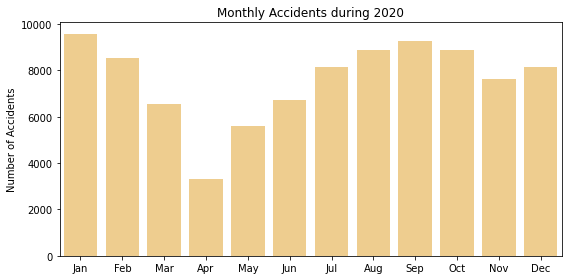

In [12]:
# agg data
monthly_accidents = accidents.groupby(pd.Grouper(key="date", freq="1M"))["accident_reference"].agg("count")

# make figure
plt.figure(figsize=(8,4))
ax = plt.gca()

# plot bar chart
sns.barplot(x=monthly_accidents.index.astype("string"), y=monthly_accidents, color="orange", alpha=0.5)

ax.set_xticklabels(monthly_accidents.index.strftime('%b'))
ax.set_title("Monthly Accidents during 2020")
ax.set_ylabel("Number of Accidents")
ax.set_xlabel('')
plt.tight_layout()

The trend of accidents dropped to the year's lowest in April but gradually increased through the rest of the months. Although we cannot tell exactly why this happened from the accident data alone.

It is possible that April has the lowest number of accidents since it have the highest number of public holidays among all months. Another possibility is due to the COVID-19 pandemic. The year 2020 was the time of COVID-19 breakout for most parts of the world. According to the United Kingdom's [COVID-19 response timeline](https://www.instituteforgovernment.org.uk/sites/default/files/timeline-lockdown-web.pdf), the lockdowns began in March as the [cases began to increase](https://coronavirus.data.gov.uk/details/cases?areaType=overview&areaName=United%20Kingdom). It is possible that fewer and fewer people goes out due to the increasing cases and lockdown restrictions. After the **FIrst wave**, restrictions get lifted slowly as people learn to adjust to the changes and traffic gradually increased.

However, this is still an assumption. We should get the traffic volume per time and check its correlation with the number of accidents to have a solid estimate of hourly number of accidents.   

## LOCATION
### Accidents by Geographical Area

In [13]:
### Load or Create the geo dataframe

# look for the geo_df dataframe and if none, create one
my_file = Path("data/geo_df.geojson") # path for geo_df

if my_file.is_file():
    geo_df = gpd.read_file(my_file) # if file is already created, use it
else:
    print("Error: Please create GeoDataFrame first in Preprocessing notebook.")

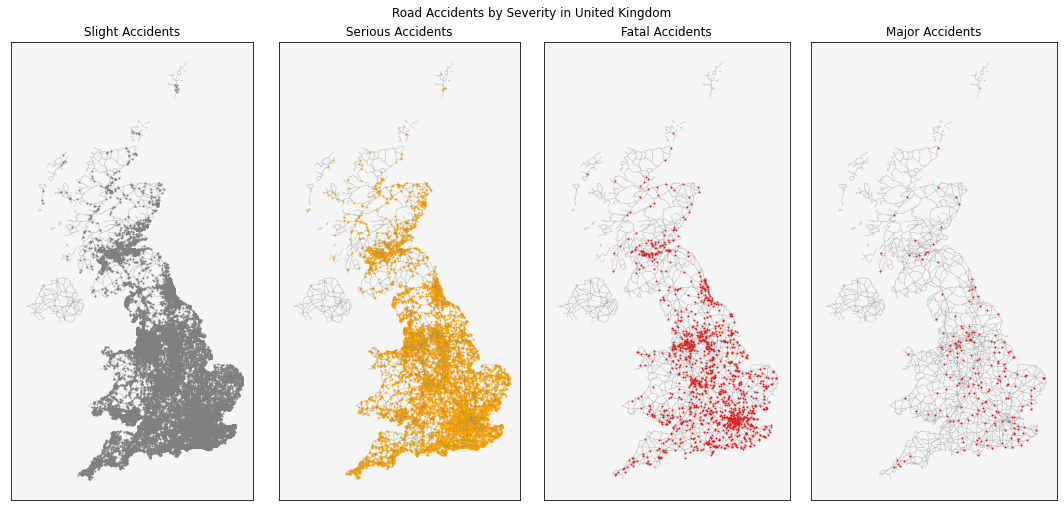

In [14]:
# load map background
roadmap = gpd.read_file("./GBR_rds/GBR_roads.shp")

# plot on map background
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(15,7))

# plot map for slight accidents
roadmap.plot(ax=ax1, alpha = 0.5, color='grey', linewidths=0.5)
geo_df[geo_df['accident_severity']=="Slight"].plot(ax=ax1, markersize=1, 
                                            color="grey", marker='o', label="Slight");
ax1.set_title("Slight Accidents")
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_facecolor("whitesmoke")

# plot map for serious accidents
roadmap.plot(ax=ax2, alpha = 0.5, color='grey', linewidths=0.5)
geo_df[geo_df['accident_severity']=="Serious"].plot(ax=ax2, markersize=1,
                                            color="orange", marker='o', label="Serious", alpha=0.9);
ax2.set_title("Serious Accidents")
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_facecolor("whitesmoke")

# plot map for fatal accidents
roadmap.plot(ax=ax3, alpha = 0.5, color="grey", linewidths=0.5)
geo_df[geo_df['accident_severity']=="Fatal"].plot(ax=ax3, markersize=1,
                                            color="red", marker='o', label="Fatal", alpha=0.9);
ax3.set_title("Fatal Accidents")
ax3.set_xticks([])
ax3.set_yticks([])
ax3.set_facecolor("whitesmoke")

# plot map for major accidents
roadmap.plot(ax=ax4, alpha = 0.5, color="grey", linewidths=0.5)
geo_df[geo_df["is_major_accident"]].plot(ax=ax4, markersize=1,
                                            color="red", marker='o', label="Major");
ax4.set_title("Major Accidents")
ax4.set_xticks([])
ax4.set_yticks([])
ax4.set_facecolor("whitesmoke")

plt.suptitle("Road Accidents by Severity in United Kingdom", y=1)
plt.tight_layout()

Generally, accidents occurs more frequently throughout locations across England compared to the rest. And the major accidents seems to be more common in England as well. But we will need to look at more granular location details to get an idea of how location influences the severity or number of accidents.

### Urban vs Rural Area Accidents

In [15]:
# aggregate accident counts for urban and rural by severity
severity_urban_rural = pd.crosstab(accidents["urban_or_rural_area"], accidents["accident_severity"])
# reorder columns by slight to fatal accidents 
severity_urban_rural = severity_urban_rural[severity_urban_rural.columns[::-1]]

# show major and non-major accidents for urban and rural areas 
major_urban_rural = pd.crosstab(accidents["urban_or_rural_area"], accidents["is_major_accident"])
major_urban_rural

is_major_accident,False,True
urban_or_rural_area,,
Rural,29295,153
Urban,61688,49


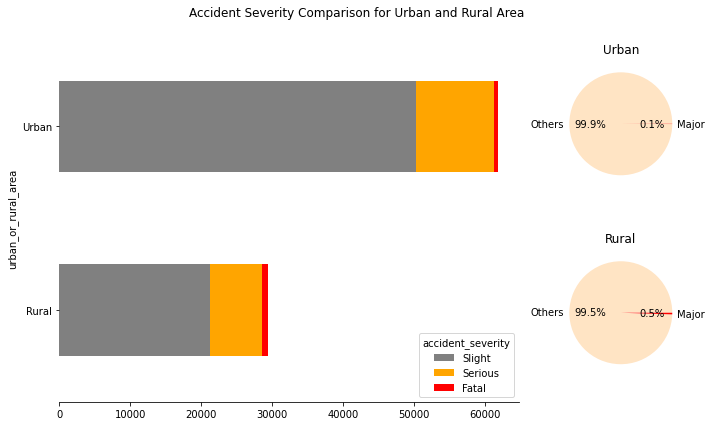

In [16]:
# make figure
plt.figure(figsize=(10,6))
ax = plt.gca()

# make grids
grid_layout = gs.GridSpec(2,4)
left = plt.subplot(grid_layout[:,:3])
upper_right = plt.subplot(grid_layout[0, 3])
lower_right = plt.subplot(grid_layout[1, 3])

# make horizontal bars
severity_urban_rural.plot(kind="barh", stacked=True, ax=left, color=severity_cmap[::-1])
left.spines["right"].set_visible(False)
left.spines["top"].set_visible(False)
left.spines["left"].set_visible(False)

# make upper pie plot
major_urban_rural.T["Urban"].plot.pie(autopct="%.1f%%", ax=upper_right, 
                                      colors=["bisque", "red"], labels=["Others", "Major"])
upper_right.set_ylabel("")
upper_right.set_title("Urban")

# make lower pie plot
major_urban_rural.T["Rural"].plot.pie(autopct="%.1f%%", ax=lower_right,\
                                      colors=["bisque", "red"], labels=["Others", "Major"])
lower_right.set_ylabel("")
lower_right.set_title("Rural")

# make suptitle
plt.suptitle("Accident Severity Comparison for Urban and Rural Area")
plt.tight_layout()

Urban areas have double the number of accidents compared to rural areas. However, the number of fatal accidents are higher in rural areas. While only 0.1% of all urban accidents are major, 0.5% of the rural accidents are accounted  major accidents. One possible reason for this is over-speeding since rural areas tends to have less traffic. Therefore, we need to take a look at the speed-limit.

## ROAD CHARACTERISTICS & FACILITIES
### Speed Limit
How does speed limit associated with accident varies for different areas?

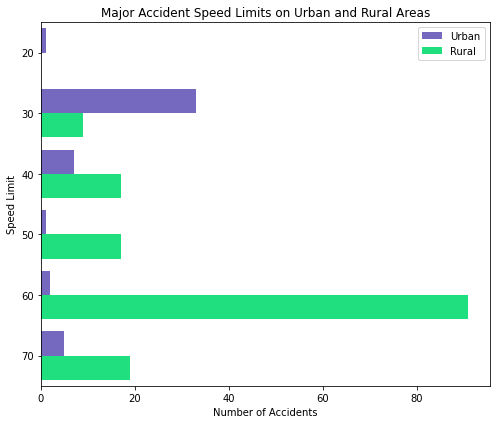

In [17]:
# get major accidents only for plotting
data = accidents[accidents.is_major_accident]

# plot
plt.figure(figsize=(7,6))
sns.countplot(y="speed_limit", data=data, hue="urban_or_rural_area", palette=["slateblue", "springgreen"])
plt.title("Major Accident Speed Limits on Urban and Rural Areas")
plt.ylabel("Speed Limit")
plt.xlabel("Number of Accidents")
plt.legend(loc="upper right")
plt.tight_layout();

As expected, we can see that a significant proportion of major accidents were rural roads with speed limit above 30. The number of accidents tends to increases as the speed limit increases.  Therefore, finding ways to monitor and regulate speeding in rural roads will help reduce the number of major accidents.

Other than speed, it is possible that urban and rural areas have differnt road characteristics that leads to high number of accidents. We will further explore the relation between road and environmental characteristics and their relations to the number of accidents. 

### Road Types
How does the number of accidents vary for different road types across urban and rural areas?

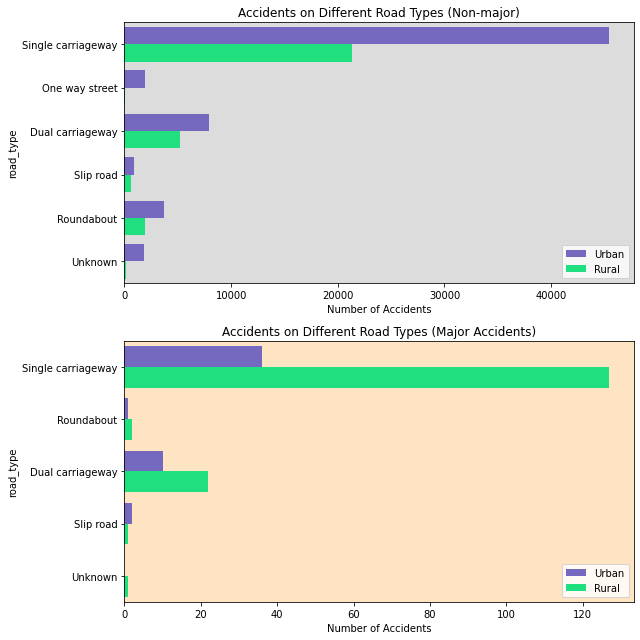

In [18]:
# make subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9,9))

# get data for Non-major accidents
data = accidents[accidents.is_major_accident == False]
# make non-major plot
sns.countplot(y="road_type", hue="urban_or_rural_area", ax=ax1,\
              data=data, palette=urban_rural_cmap)
ax1.set_facecolor("gainsboro")
ax1.set_xlabel("Number of Accidents")
ax1.legend(loc="lower right")
ax1.set_title("Accidents on Different Road Types (Non-major)")

# get data for major accidents
data = accidents[accidents.is_major_accident]
# make major plot
sns.countplot(y="road_type", hue="urban_or_rural_area", ax=ax2,\
              data=data, palette=urban_rural_cmap)
ax2.set_facecolor("bisque")
ax2.set_xlabel("Number of Accidents")
ax2.set_title("Accidents on Different Road Types (Major Accidents)")
ax2.legend(loc="lower right")
plt.tight_layout()

By far, single carriageways are the most hazardous since most accidents happened on those types of roads. A large proportion of major accidents also happened on those roads especially in rural areas. </span>  In comparison, dual carriageways are far less hazardous. This might be related to the space available for vehicles to change lanes. Paying attention to gather features of single carriageways and studying how accidents happened on those roads may give some idea on how to reduce the number of major accidents.

For further analysis, we can look at the number of lanes and the width of the roads to have better idea of how major accidents happened. Let's start from the junctions details related to accidents.

### Type of Junction
What kind of junctions are the most hazardous?

In [19]:
# manually rename junction details since names in lookup are too long & take lots of space
junction_detail_names = {0: "No junction/within 20m",\
                         1: "Roundabout",\
                         2: "Mini-roundabout",\
                         3: "T/staggered junction",\
                         5: "Slip road",\
                         6: "Crossroads",\
                         7: ">4 arms(not roundabout)",\
                         8: "Private drive/enterence",\
                         9: "other junction",\
                         99: "unknown(self-reported)",\
                         -1: "data missing/out of range"}
accidents.junction_detail = accidents.junction_detail.replace(junction_detail_names)

# shrink junction detail name text for pie plots
junction_detail_names = {"No junction/within 20m": "no junction",\
                         "Mini-roundabout": "others",\
                         "T/staggered junction": "T / Staggered",\
                         "Slip road": "others",\
                         ">4 arms(not roundabout)": "others",\
                         "Private drive/enterence": "others",\
                         "other junction": "others",\
                         "unknown(self-reported)": "others",\
                         "data missing/out of range": "others"}

#### Accidents in Each Junction Type (Urban & Rural Areas)

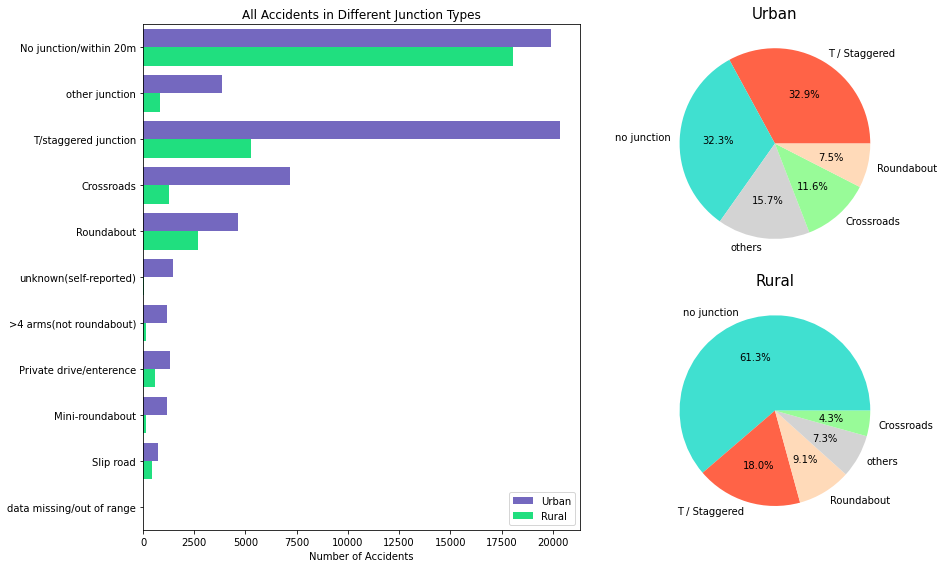

In [20]:
# make figure
plt.figure(figsize=(14,8))
ax = plt.gca()

# make grids
grid_layout = gs.GridSpec(2,2)
left = plt.subplot(grid_layout[:,0])
right_top = plt.subplot(grid_layout[0, 1])
right_bottom = plt.subplot(grid_layout[1, 1])

# make horizontal countplot
sns.countplot(y="junction_detail", hue="urban_or_rural_area", ax=left,\
              data=accidents, palette=urban_rural_cmap)
left.set_xlabel("Number of Accidents")
left.set_ylabel("")
left.set_title("All Accidents in Different Junction Types")
left.legend(loc="lower right")

# plot upper right pie
data = accidents[accidents.urban_or_rural_area=="Urban"].junction_detail
data = data.replace(junction_detail_names).value_counts()
data.plot.pie(autopct="%.1f%%", ax=right_top,\
              colors=["tomato", "turquoise", "lightgrey", "palegreen", "peachpuff", "yellow"])
right_top.set_ylabel("")
right_top.set_title("Urban", fontsize=15)

# plot lower right pie
data = accidents[accidents.urban_or_rural_area=="Rural"].junction_detail
data = data.replace(junction_detail_names).value_counts()
data.plot.pie(autopct="%.1f%%", ax=right_bottom,\
              colors=["turquoise", "tomato", "peachpuff", "lightgrey", "palegreen", "yellow"])
right_bottom.set_ylabel("")
right_bottom.set_title("Rural", fontsize=15)

plt.tight_layout()

Top 2 hazardous locations are:
1. No junction or within 20 m and
2. T or staggered junctions.

Accidents are equally likely to happen in roads segments without junction in both urban and rural areas. Rural areas have fewer junctions compared to urban areas and thus have fewer accidents related to junction. Therefore, safety at T or staggered junctions should be a concern for urban regions. 

For rural areas, having fewer junctions lead to the increased speed limits and consequently causes more accidents in single carriageways with high speed limits. Since higher percentage of major accidents happened in rural areas, speed regulations and making modifications to single carriageway should take priority. In the graph below, we will take a look at junction details of the major accidents.

#### Major Accidents in Each Junction Types

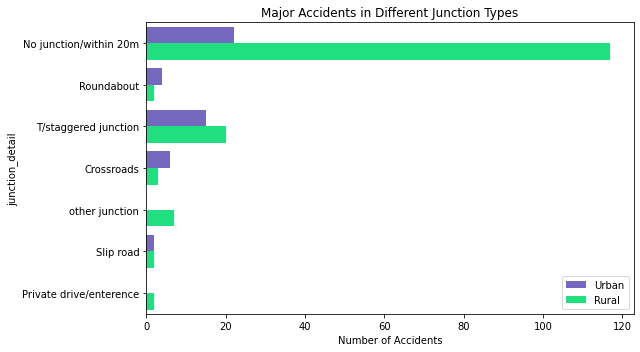

In [21]:
# get major accidents only
data = accidents[accidents.is_major_accident]

plt.figure(figsize=(9,5))
sns.countplot(y="junction_detail", hue="urban_or_rural_area",\
              data=data, palette=urban_rural_cmap)
plt.xlabel("Number of Accidents")
plt.title("Major Accidents in Different Junction Types")
plt.legend(loc="lower right")
plt.tight_layout();

For the major accidents alone,  "T or staggered junctions" and "no junction" are most common place of accident. We find that very high number of accidents happened on rural roads without junctions. This reinforces that speed regulation is a problem for rural areas because drivers tend to go overspeed in roads without junctions.  

Now, we will move on to the junction control conditions for each junction of our concern.

### Junction Control Conditions
Is there any junction control conditions that make a junction more suspectible to accidents?

In [22]:
# manually rename junction control since names in lookup are too long
junction_control_name = {-1: "Data missing/out of range",\
                          1: "Authorised person",\
                          2: "Auto traffic signal",\
                          3: "Stop sign",\
                          4: "Give way/uncontrolled",\
                          9: "unknown(self-reported)"}
accidents.junction_control = accidents.junction_control.replace(junction_control_name)

#### T or Staggered Junction

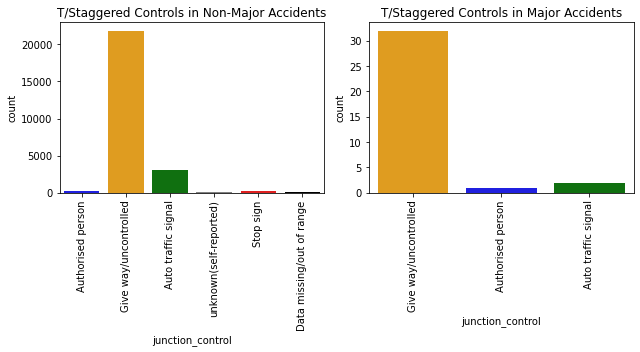

In [23]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(9,5))

# plot junction control for Non-major : T or staggered
data = accidents.query("(is_major_accident==False) & (junction_detail=='T/staggered junction')")
sns.countplot(data=data, x="junction_control", ax=ax1, palette=["blue", "orange", "green", "grey", "red", "black"])
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
ax1.set_title("T/Staggered Controls in Non-Major Accidents")

# plot junction control for Major : T or staggered
data = accidents.query("(is_major_accident==True) & (junction_detail=='T/staggered junction')")
sns.countplot(data=data, x="junction_control", ax=ax2, palette=["orange", "blue", "green"])
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)
ax2.set_title("T/Staggered Controls in Major Accidents")

plt.tight_layout()

The number of accidents are very high for the T/staggered junctions with give-way signs or uncontrolled ones both for major and non-major accidents. Therefore, T/staggered junctions would be safer to have auto traffic signals. 

#### Crossroads

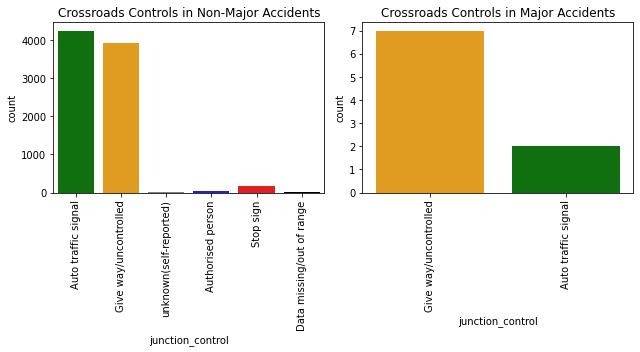

In [24]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(9,5))

# plot junction control for Non-major : Crossroads
data = accidents.query("(is_major_accident==False) & (junction_detail=='Crossroads')")
sns.countplot(data=data, x="junction_control", ax=ax1, palette=["green", "orange", "grey", "blue", "red", "black"])
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
ax1.set_title("Crossroads Controls in Non-Major Accidents")

# plot junction control for Major : Crossroads
data = accidents.query("(is_major_accident==True) & (junction_detail=='Crossroads')")
sns.countplot(data=data, x="junction_control", ax=ax2, palette=["orange", "green"])
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)
ax2.set_title("Crossroads Controls in Major Accidents")

plt.tight_layout()

For crossroads, we can still see a high number of accidents involved with give-way or uncontrolled junction controls. Therefore, this kind of junction control might not be an effective way to regulate traffic.

#### Roundabout

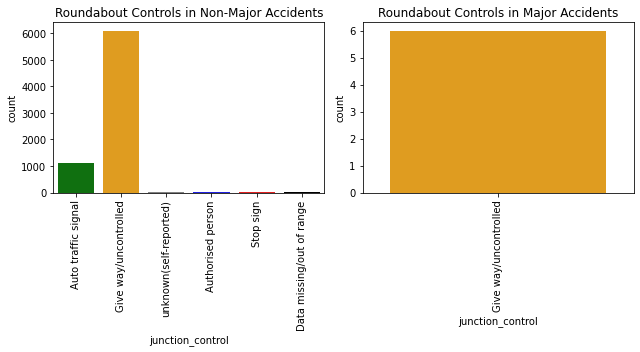

In [25]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(9,5))

# plot junction control for Non-major : Roundabout
data = accidents.query("(is_major_accident==False) & (junction_detail=='Roundabout')")
sns.countplot(data=data, x="junction_control", ax=ax1, palette=["green", "orange", "grey", "blue", "red", "black"])
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
ax1.set_title("Roundabout Controls in Non-Major Accidents")

# plot junction control for Major : Roundabout
data = accidents.query("(is_major_accident==True) & (junction_detail=='Roundabout')")
sns.countplot(data=data, x="junction_control", ax=ax2, palette=["orange", "green"])
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)
ax2.set_title("Roundabout Controls in Major Accidents")

plt.tight_layout()

From the data we have seen so far, we can say that having authorized persons or stop signs are the safest form of junction control. Since most junction accidents are involved wiht give-way signs or uncontrolled junctions, the safety team should work on more effective type of control facility for suspectible junctions. Next, let's look at pedestrian crossings.

### Pedestrian Crossings

In [26]:
accidents[accidents.is_major_accident==1].pedestrian_crossing_physical_facilities.value_counts()

No physical crossing facilities within 50 metres                             190
Central refuge                                                                 5
Pedestrian phase at traffic signal junction                                    3
Pelican, puffin, toucan or similar non-junction pedestrian light crossing      2
Zebra                                                                          1
Footbridge or subway                                                           1
Name: pedestrian_crossing_physical_facilities, dtype: int64

Since most major accidents happened in places without crossing facilities, we can assume that existing pedestrian crossing facilitie areas are quite safe already. 

Now that we have checked all the man made physical facilities, we will move on to some special conditions such as weather, road conditions and other hazards.

### Special Conditions at Accident Site

In [27]:
accidents.special_conditions_at_site.value_counts()

None                                          87295
unknown (self reported)                        1452
Roadworks                                      1106
Mud                                             317
Road surface defective                          228
Data missing or out of range                    218
Auto traffic signal - out                       213
Road sign or marking defective or obscured      158
Oil or diesel                                   151
Auto signal part defective                       47
Name: special_conditions_at_site, dtype: int64

We will filter out the accidents that are not associated with any special conditions to see how each special condition affects the severity.

#### Special Conditions in Rural Areas 

In [52]:
# use only accidents with special conditions involved for rural area
rural_data = accidents.query("(special_conditions_at_site!='None') & (urban_or_rural_area=='Rural')")
rural_data.accident_severity.value_counts()

Slight     837
Serious    274
Fatal       27
Name: accident_severity, dtype: int64

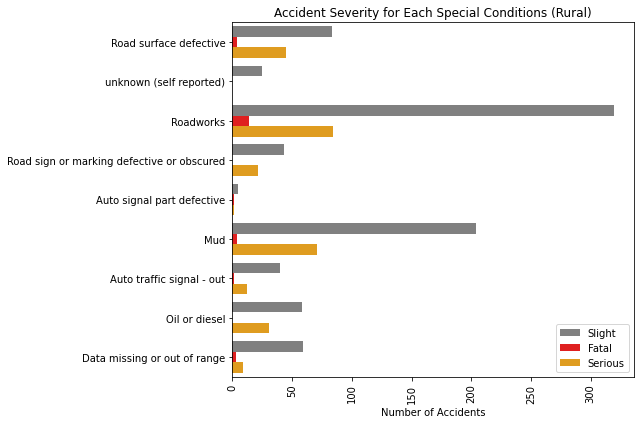

In [53]:
plt.figure(figsize=(9,6))
sns.countplot(data=rural_data, y="special_conditions_at_site", hue="accident_severity",\
              palette=(severity_cmap[2], severity_cmap[0], severity_cmap[1]))
plt.xticks(rotation=90)
plt.xlabel("Number of Accidents")
plt.ylabel("")
plt.title("Accident Severity for Each Special Conditions (Rural)")
plt.legend(loc="lower right")
plt.tight_layout();

Among the special conditions in rural areas, roadworks, mud, and defective road surface are associated with a high numbers of accidents in total. Moreover, they are also associated with most fatal accidents. We'll also look at this data for urban areas.

#### Special Conditions in Urban Areas

In [55]:
# use only accidents with special conditions involved for rural area
urban_data = accidents.query("(special_conditions_at_site!='None') & (urban_or_rural_area=='Urban')")
urban_data.accident_severity.value_counts()

Slight     2388
Serious     353
Fatal        11
Name: accident_severity, dtype: int64

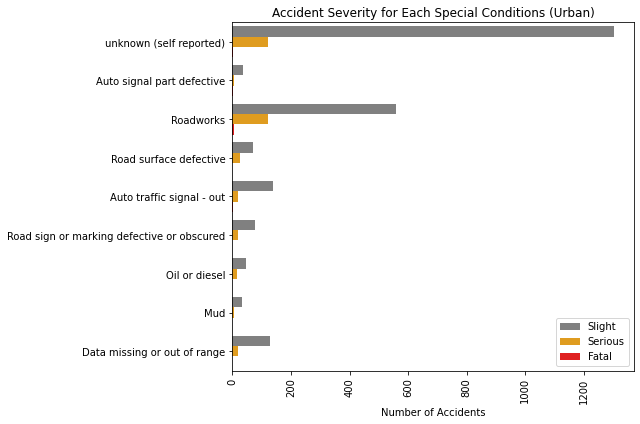

In [29]:
plt.figure(figsize=(9,6))
sns.countplot(data=urban_data, y="special_conditions_at_site", hue="accident_severity",\
              palette=severity_cmap[::-1])
plt.xticks(rotation=90)
plt.xlabel("Number of Accidents")
plt.ylabel("")
plt.title("Accident Severity for Each Special Conditions (Urban)")
plt.legend(loc="lower right")
plt.tight_layout();

As for urban areas, we see very few fatal accidents involved in special conditions except for a small number in roadworks. Therefore, special conditions have more harmful effects on rural area traffic. Below, we have compared how many percent of each special condition is involved in fatal accidents.

#### Fatal Accident Percent for Each Special Condition

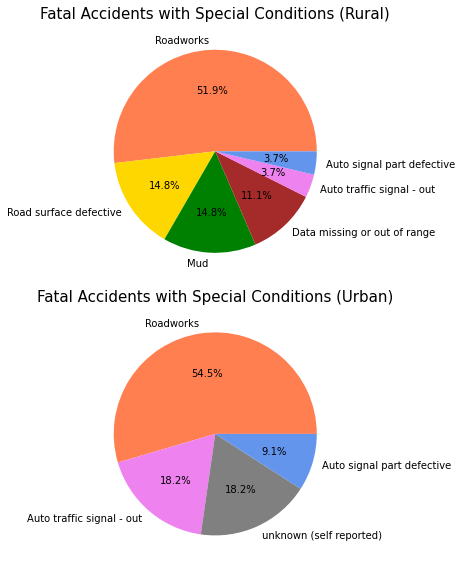

In [30]:
fig, (top, bottom) = plt.subplots(2,1, figsize=(10,8))

# for rural area
data = accidents.query("((special_conditions_at_site!='None') & (accident_severity=='Fatal'))\
                            & (urban_or_rural_area=='Rural')")
data.special_conditions_at_site.value_counts().plot.pie(autopct="%.1f%%", ax=top,\
                                colors=["coral", "gold", "green", "brown", "violet", "cornflowerblue"])
top.set_ylabel('')
top.set_title("Fatal Accidents with Special Conditions (Rural)", fontsize=15)

# for urban area
data = accidents.query("((special_conditions_at_site!='None') & (accident_severity=='Fatal'))\
                            & (urban_or_rural_area=='Urban')")
data.special_conditions_at_site.value_counts().plot.pie(autopct="%.1f%%", ax=bottom,\
                                colors=["coral", "violet", "grey", "cornflowerblue"])
bottom.set_ylabel('')
bottom.set_title("Fatal Accidents with Special Conditions (Urban)", fontsize=15)

plt.tight_layout()

Considering only the special conditions for fatal accidents, roadworks are the most common for both rural and urban areas. Other potential hazard varies depending on the area. Mud and defective road surfaces are risky particularly in rural areas while defective traffic signal are a problem for urban areas.

Next, we will see the road surface characteristics associated with major accidents.

### Road Surface Characteristics
Does some road surface conditions cause more major accidents than others?

In [31]:
accidents.road_surface_conditions.value_counts()

Dry                             62687
Wet or damp                     26238
unknown (self reported)           847
Frost or ice                      764
Data missing or out of range      315
Flood over 3cm. deep              184
Snow                              150
Name: road_surface_conditions, dtype: int64

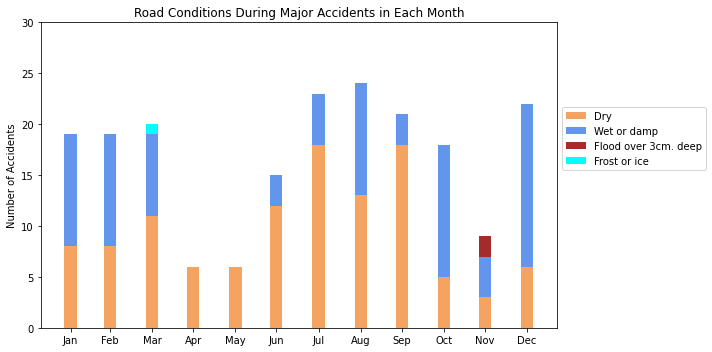

In [32]:
# aggregate data only for major accidents
maj_data = accidents[accidents.is_major_accident==1]
data = maj_data.groupby(pd.Grouper(key="date", freq="1M"))["road_surface_conditions"]\
                    .agg(val_counts = ("value_counts"))

# get all road surf conditions and months from agg data
road_surf_conditions = maj_data.road_surface_conditions.value_counts().index
months = data.index.get_level_values(0).unique()

# make figure
plt.figure(figsize=(10,5))
ax = plt.gca()

## draw stacked bar chart
colors = ["sandybrown", "cornflowerblue", "brown", "cyan"]
bottom = np.zeros(len(months))
color_count = 0
for condition in road_surf_conditions:
    temp_bar_height = list()
    for i in months:
        temp_dict = data.loc[i].val_counts.to_dict()
        temp_bar_height.append(temp_dict.get(condition, 0))
        
    ax.bar(x = months, height=temp_bar_height, bottom=bottom, width=9,\
           label=condition, color=colors[color_count])
    bottom = [sum(x) for x in zip(bottom, temp_bar_height)]
    color_count += 1
    
ax.set_ylim(0,30)
ax.set_xticks(months)
ax.set_xticklabels(months.strftime('%b'))
ax.set_ylabel("Number of Accidents")
plt.title("Road Conditions During Major Accidents in Each Month")
plt.legend(loc="lower left", bbox_to_anchor=(1, 0.5))
plt.tight_layout()

Dry or wet road conditions is the most common throughout all months and therefore, most accidents are involved with those. As for other road conditions, we see very few major accidents involved. Weather conditions could be the major cause of road conditions such as wet or dry.


## WEATHER & ENVIRONMENT
### Monthly Weather Conditions and Accident Severity

In [33]:
accidents.weather_conditions.value_counts()

Fine no high winds              70720
Raining no high winds           11581
Other                            2629
Unknown                          2421
Raining + high winds             1665
Fine + high winds                1400
Fog or mist                       510
Snowing no high winds             185
Snowing + high winds               73
Data missing or out of range        1
Name: weather_conditions, dtype: int64

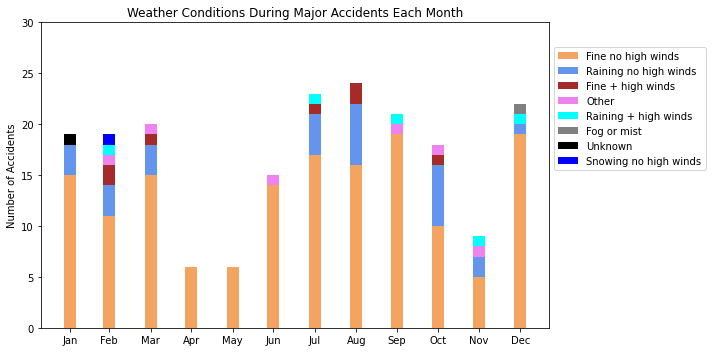

In [34]:
# aggregate data only for major accidents
maj_data = accidents[accidents.is_major_accident]
data = maj_data.groupby(pd.Grouper(key="date", freq="1M"))["weather_conditions"]\
                    .agg(val_counts = ("value_counts"))

# get all road surf conditions and months from agg data
weather_conditions = maj_data.weather_conditions.value_counts().index

colors = ["sandybrown", "cornflowerblue", "brown", "violet", "cyan", "grey", "black", "blue"]
months = data.index.get_level_values(0).unique()

# make figure
plt.figure(figsize=(10,5))
ax = plt.gca()

## draw stacked bar chart
bottom = np.zeros(len(months))
color_count = 0
for condition in weather_conditions:
    temp_bar_height = list()
    for i in months:
        temp_dict = data.loc[i].val_counts.to_dict()
        temp_bar_height.append(temp_dict.get(condition, 0))
    ax.bar(x = months, height=temp_bar_height, bottom=bottom, width=9,\
           label=condition, color=colors[color_count])
    bottom = [sum(x) for x in zip(bottom, temp_bar_height)]
    color_count += 1
    
ax.set_ylim(0,30)
ax.set_xticks(months)
ax.set_xticklabels(months.strftime('%b'))
ax.set_ylabel("Number of Accidents")
plt.title("Weather Conditions During Major Accidents Each Month")
plt.legend(loc="lower left", bbox_to_anchor=(1, 0.5))
plt.tight_layout()

Throughout all months, most accidents happened during fine weather or raining without high winds. Although accidents involving other weather conditions are fewer in comparison, we still need to see which weather condition is associated with severe accidents.

#### Accident Severity Variations in Different Weather Conditions

In [35]:
# get rows without missing weather data since we only want to check weather related accidents
data = accidents.query("weather_conditions!='Data missing or out of range'")\
        [["weather_conditions", "accident_severity"]]
data = pd.crosstab(data.accident_severity, data.weather_conditions, normalize="columns").round(3)
data

weather_conditions,Fine + high winds,Fine no high winds,Fog or mist,Other,Raining + high winds,Raining no high winds,Snowing + high winds,Snowing no high winds,Unknown
accident_severity,,,,,,,,,
Fatal,0.024,0.016,0.035,0.008,0.024,0.012,0.014,0.011,0.006
Serious,0.245,0.206,0.237,0.156,0.213,0.188,0.205,0.232,0.125
Slight,0.731,0.778,0.727,0.836,0.763,0.801,0.781,0.757,0.869


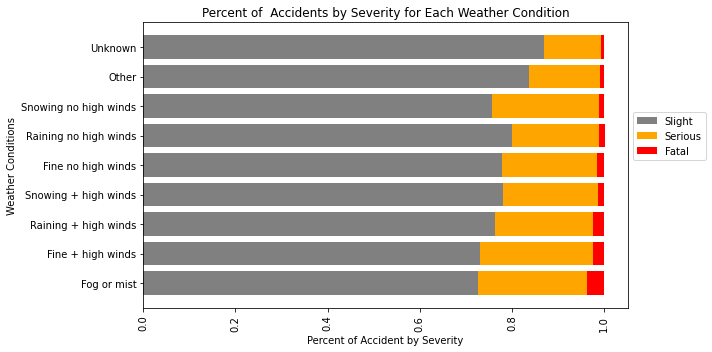

In [36]:
weather_conditions = ["Fog or mist", "Fine + high winds", "Raining + high winds", "Snowing + high winds",\
                      "Fine no high winds", "Raining no high winds", "Snowing no high winds",\
                      "Other", "Unknown"]

# make figure
plt.figure(figsize=(10,5))
ax = plt.gca()

## draw stacked bar chart
bottom = np.zeros(len(weather_conditions))
color_count = 2
for severity in data.index[::-1]:
    bar_height = data.loc[severity].reindex(weather_conditions).fillna(0)
    ax.barh(weather_conditions, bar_height, left=bottom, label=severity, color=severity_cmap[color_count])
    bottom = [sum(x) for x in zip(bottom, bar_height)]
    color_count -= 1
    
plt.xticks(rotation=90)
ax.set_ylabel("Weather Conditions")
ax.set_title("Percent of  Accidents by Severity for Each Weather Condition")
ax.set_xlabel("Percent of Accident by Severity")
plt.legend(loc="lower left", bbox_to_anchor=(1, 0.5))
plt.tight_layout()

In terms of percentage, accidents in fog and mist tends to be more severe. High wind conditions are generally more dangerous than no wind.

### Accident Severity of Carriageway Hazards

In [37]:
data = pd.crosstab(accidents.accident_severity, accidents.carriageway_hazards, normalize="columns").round(3)
data

carriageway_hazards,Any animal in carriageway (except ridden horse),Data missing or out of range,None,Other object on road,Pedestrian in carriageway - not injured,Previous accident,Vehicle load on road,unknown (self reported)
accident_severity,,,,,,,,
Fatal,0.006,0.014,0.015,0.021,0.039,0.046,0.000,0.001
Serious,0.252,0.135,0.202,0.242,0.168,0.252,0.145,0.085
Slight,0.742,0.851,0.782,0.737,0.794,0.702,0.855,0.914


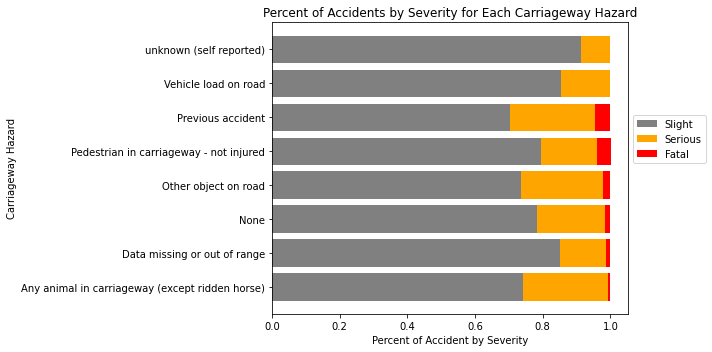

In [38]:
# make figure
plt.figure(figsize=(10,5))
ax = plt.gca()

## draw stacked bar chart
bottom = np.zeros(len(data.columns))
color_count = 2
for severity in data.index[::-1]:
    bar_height = data.loc[severity].reindex(data.columns).fillna(0)
    ax.barh(data.columns, bar_height, left=bottom, label=severity, color=severity_cmap[color_count])
    bottom = [sum(x) for x in zip(bottom, bar_height)]
    color_count -= 1

ax.set_title("Percent of Accidents by Severity for Each Carriageway Hazard")
ax.set_ylabel("Carriageway Hazard")
ax.set_xlabel("Percent of Accident by Severity")
plt.legend(loc='lower left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()

Places of previous accident, pedestrian in carriageway, and object on road are the top 3 carriageway hazards with highest percent of fatal accidents.

### Light Conditions
#### Accident Severity in Each Light Condition

In [39]:
accidents.light_conditions.value_counts()

Daylight                        64448
Darkness - lights lit           19025
Darkness - no lighting           4834
Darkness - lighting unknown      2192
Darkness - lights unlit           685
Data missing or out of range        1
Name: light_conditions, dtype: int64

In [40]:
# get rows without missing light condition data 
data = accidents[accidents.light_conditions!="Data missing or out of range"]
data = pd.crosstab(data.accident_severity, data.light_conditions, normalize="columns").round(4)
data

light_conditions,Darkness - lighting unknown,Darkness - lights lit,Darkness - lights unlit,Darkness - no lighting,Daylight
accident_severity,,,,,
Fatal,0.0100,0.0153,0.0292,0.0523,0.0125
Serious,0.1296,0.2078,0.2190,0.2739,0.1961
Slight,0.8604,0.7769,0.7518,0.6738,0.7914


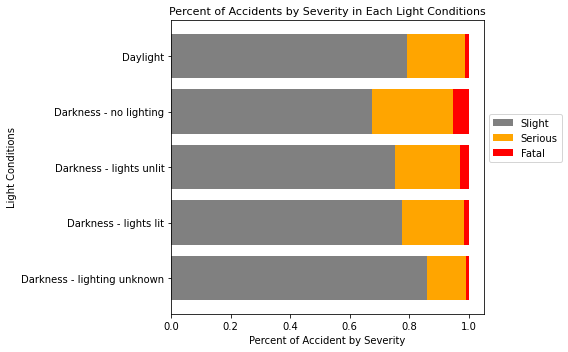

In [41]:
# make figure
plt.figure(figsize=(8,5))
ax = plt.gca()

## draw stacked bar chart
bottom = np.zeros(len(data.columns))
color_count = 2
for severity in data.index[::-1]:
    bar_height = data.loc[severity].reindex(data.columns).fillna(0)
    ax.barh(data.columns, bar_height, left=bottom,\
            label=severity, color=severity_cmap[color_count])
    bottom = [sum(x) for x in zip(bottom, bar_height)]
    color_count -= 1


ax.set_title("Percent of Accidents by Severity in Each Light Conditions", fontsize=11)
ax.set_ylabel("Light Conditions")
ax.set_xlabel("Percent of Accident by Severity")
plt.legend(loc='lower left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()

Lighting reduces the percentage of severe accidents since times with darkness have larger ratio of severe accidents than during the daylight.

#### Urban vs Rural Light Conditions

In [42]:
light_names = {'Darkness - lights lit': 'Dark/lights on',
               'Darkness - lights unlit': 'Dark/lights off',
               'Darkness - no lighting': 'Dark/no light',
               'Darkness - lighting unknown': 'Dark/unknown',
               'Daylight': 'Daylight'}

light_colors = {'Darkness - lights lit': 'darkgrey',
               'Darkness - lights unlit': 'red',
               'Darkness - no lighting': 'black',
               'Darkness - lighting unknown': 'peru',
               'Daylight': 'yellow'}

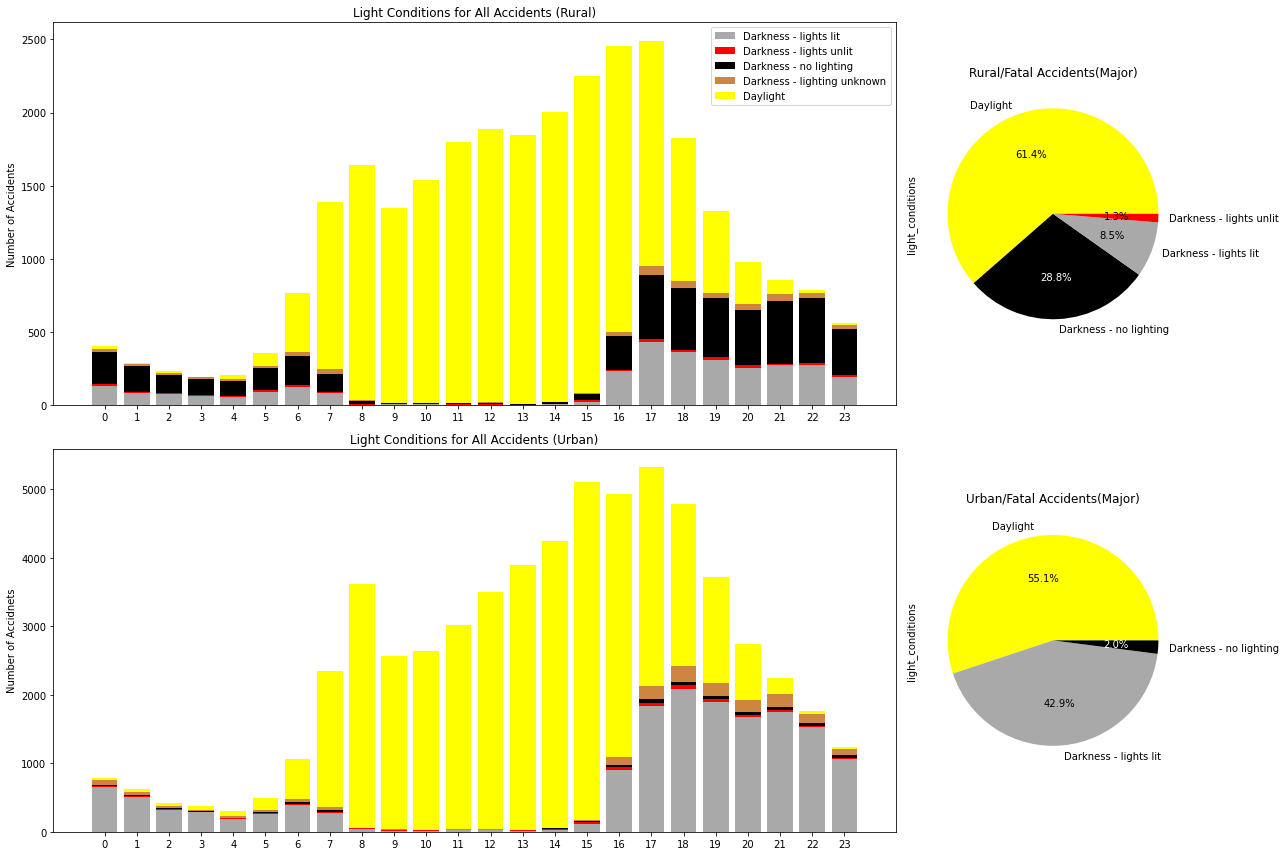

In [43]:
# remove unknown light condtions accidents
data = accidents.query("light_conditions!='Data missing or out of range'")

hour_vals = sorted(accidents.hour.unique())

# make figure
plt.figure(figsize=(18,12))
upper_left = plt.gca() 

# define grids
grid_layout = gs.GridSpec(2,4)
upper_left = plt.subplot(grid_layout[0,:3])
lower_left = plt.subplot(grid_layout[1,:3])
upper_right = plt.subplot(grid_layout[0, 3])
lower_right = plt.subplot(grid_layout[1, 3])

# __plot bar for Rural light conditions__
# aggerate data
rural_bar = data.query("urban_or_rural_area=='Rural'")
rural_bar = rural_bar.groupby(["hour"])["light_conditions"].agg(val_counts = ("value_counts"))
bottom = np.zeros(len(hour_vals))
# for each light condition
for light_condit in light_names.keys():
    temp_bar_height = list()
    # for each hour in current light condit
    for hour in hour_vals:
        # get light_conditions
        temp_dict = rural_bar.loc[hour].val_counts.to_dict() 
        # get value counts of each light condition
        temp_bar_height.append(temp_dict.get(light_condit, 0))
    upper_left.bar(x = hour_vals, height=temp_bar_height, bottom=bottom,\
           label=light_condit, color = light_colors[light_condit])
    bottom = [sum(x) for x in zip(bottom, temp_bar_height)]
    
# __plot bar for Urban light conditions__
# aggerate data
urban_bar = data.query("urban_or_rural_area=='Urban'")
urban_bar = urban_bar.groupby(["hour"])["light_conditions"].agg(val_counts = ("value_counts"))
bottom = np.zeros(len(hour_vals))
# for each light condition
for light_condit in light_names.keys():
    temp_bar_height = list()
    # for each hour in current light condit
    for hour in hour_vals:
        # get light_conditions
        temp_dict = urban_bar.loc[hour].val_counts.to_dict() 
        # get value counts of each light condition
        temp_bar_height.append(temp_dict.get(light_condit, 0))
    lower_left.bar(x = hour_vals, height=temp_bar_height, bottom=bottom,\
           label=light_condit, color = light_colors[light_condit])
    bottom = [sum(x) for x in zip(bottom, temp_bar_height)]

# __plot pie for Rural light conditions__
rural_pie = data.query("(urban_or_rural_area=='Rural') & (is_major_accident==True)").\
                    light_conditions.value_counts()
labels = rural_pie.index
rural_pie_plot = rural_pie.plot.pie(autopct="%.1f%%", ax=upper_right,\
                                    colors=[light_colors[key] for key in labels])
# make percent label visible
rural_pie_plot.get_children()[7].set_color("white")


# __plot pie for Urban light conditions__
urban_pie = data.query("(urban_or_rural_area=='Urban') & (is_major_accident==True)").\
                    light_conditions.value_counts()
labels = urban_pie.index
urban_pie_plot = urban_pie.plot.pie(autopct="%.1f%%", ax=lower_right,\
                                    colors=[light_colors[key] for key in labels])
# make percent label visible\
urban_pie_plot.get_children()[8].set_color("white")

upper_left.legend()
upper_left.set_title("Light Conditions for All Accidents (Rural)")
lower_left.set_title("Light Conditions for All Accidents (Urban)")
upper_left.set_xticks(hour_vals)
lower_left.set_xticks(hour_vals)
upper_left.set_ylabel("Number of Accidents")
lower_left.set_ylabel("Number of Accidnets")

upper_right.set_title("Rural/Fatal Accidents(Major)")
lower_right.set_title("Urban/Fatal Accidents(Major)")

plt.tight_layout();

High number of accidents in rural area could be due to insufficient lighting. This is because very few severe accidents in urban area happened in darkenss and urban areas have fewer number of total major accidents than rural places. 

# Conclusion


In general, safety team should use more resource for traffic control, speed regulation, and emergency response plans for times with highest number of accidents. For rural areas, it will be safer with more lighting and speed regulation measures. It is also necessary to check if junctions have appropriate type of junction control. Drivers' awareness of hazards in some weather and special conditions is also necessary.

# Futuer Work

This analysis, by no means, is complete especially because it only uses 2020 data alone. However, it gave some clue of what might be going on with some trends and patterns that should be carefully observed for other years. For more granular estimate of locations, addresses can be reverse geocoded with Photon's API in geopanda. In order to develop a predictive model, hourly traffic flows will be a good variable to have along with other locational and environmental features.